In [20]:
import numpy as np
import time
import os
import pathlib
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import io
import random
import seaborn as sns # ploting utility
from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
#from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

#Plot model architecture
import pydot
import graphviz
from tensorflow.keras.utils import plot_model
import pydotplus

import warnings
warnings.filterwarnings('ignore')

#Import libaries for a single image
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

#Load model library
from tensorflow.keras.models import load_model

In [28]:
labels = ['CONTROL', 'AD', 'PD']

In [29]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

X_test = [] #Test Dataset
Y_test = [] #Test Labels

image_size=176

for i in labels:
    folderPath = os.path.join('C:\\Users\\IDDY R SWALEHE\\Desktop\\PET_PNG_FINAL', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('C:\\Users\\IDDY R SWALEHE\\Desktop\\PET_PNG_FINAL', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(i)
        
#Image and Label is appended as list, now is to be converted into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

#Image and Label is appended as list, now is to be converted into array
X_test = np.array(X_test)
Y_test = np.array(Y_test)


100%|██████████| 250/250 [00:00<00:00, 904.46it/s]


In [30]:
X_train.shape #No of sample = 6027

(5862, 176, 176, 3)

In [31]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [32]:
#After shuffling sample size remains same
X_train.shape

(5862, 176, 176, 3)

In [33]:
#After shuffling sample size remains same
Y_train.shape

(5862,)

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [35]:
#converting string label to categoriacal
y_train_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))#Converting String Label to integer i.e
                                       # CONTROL ---> 0, AD---> 1, PD ---> 2
Y_train = to_categorical(y_train_new) #Converts a class vector (integers) to binary class matrix

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

In [36]:
Y_train

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [37]:
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = ModelCheckpoint("Modified_Model2_classification between AD and PD using new_dataset7_AD_03_04_2024.h5",
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                             min_delta=0.001)

es = EarlyStopping(monitor='val_acc',
                   patience=5,
                   verbose=1,
                   mode='auto',
                   restore_best_weights=True) 

In [38]:
#5. Building the model

model = tf.keras.models.Sequential()
INPUT_SHAPE =(image_size, image_size, 3)
model.add(tf.keras.layers.Rescaling(scale=1./255, input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 176, 176, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 176, 176, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 88, 88, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 88, 88, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 44, 44, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 64)       

In [39]:
#Configures the model for training
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

In [40]:
start_time = time.time()

history = model.fit(X_train, 
                    Y_train,
                    batch_size=32,
                    validation_data=(X_test,Y_test),
                    epochs=50,
                    verbose=1,
                   callbacks=[tensorBoard, checkPoint, reduce_lr, es])

end_time = time.time()
training_time = (end_time - start_time)

print("Training Time: {:.4f} minutes".format(training_time/60))

Epoch 1/50


165/165 [==============================] - ETA: 0s - loss: 0.3621 - acc: 0.8461
Epoch 1: val_acc improved from -inf to 0.92164, saving model to Modified_Model2_classification between AD and PD using new_dataset7_AD_03_04_2024.h5
165/165 [==============================] - 58s 330ms/step - loss: 0.3621 - acc: 0.8461 - val_loss: 0.2340 - val_acc: 0.9216 - lr: 0.0010
Epoch 2/50
165/165 [==============================] - ETA: 0s - loss: 0.2075 - acc: 0.9227
Epoch 2: val_acc improved from 0.92164 to 0.95741, saving model to Modified_Model2_classification between AD and PD using new_dataset7_AD_03_04_2024.h5
165/165 [==============================] - 52s 313ms/step - loss: 0.2075 - acc: 0.9227 - val_loss: 0.1192 - val_acc: 0.9574 - lr: 0.0010
Epoch 3/50
165/165 [==============================] - ETA: 0s - loss: 0.1175 - acc: 0.9543
Epoch 3: val_acc improved from 0.95741 to 0.97956, saving model to Modified_Model2_classification between AD and PD using new_dataset7_AD_03_04_2024.h

In [43]:
model_evaluate = model.evaluate(X_train, Y_train)
print("Training_Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Training_Loss: %", "{:.2f}".format(model_evaluate[0]*100))

print('\n')

# b)Testing
model_evaluate = model.evaluate(X_test, Y_test)
print("Test_Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Test_Loss: %", "{:.2f}".format(model_evaluate[0]*100))

165/165 [==============================] - 18s 106ms/step - loss: 0.0024 - acc: 1.0000
Training_Accuracy: % 100.00
Training_Loss: % 0.24


19/19 [==============================] - 2s 110ms/step - loss: 0.0116 - acc: 0.9966
Test_Accuracy: % 99.66
Test_Loss: % 1.16


In [42]:
#Load a model
model = load_model('Modified_Model2_classification PET_PNG_dataset_10_04_2024_10_04_2024.h5')

In [44]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, pred))

19/19 [==============================] - 2s 104ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      0.99      1.00       382
           2       0.98      1.00      0.99       112

    accuracy                           1.00       587
   macro avg       0.99      1.00      1.00       587
weighted avg       1.00      1.00      1.00       587



In [45]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(Y_test, axis=1)

# Calculate true positives, false positives, true negatives, false negatives
tp = np.sum(np.logical_and(pred == actual_label, pred == 1))
fp = np.sum(np.logical_and(pred != actual_label, pred == 1))
tn = np.sum(np.logical_and(pred == actual_label, pred == 0))
fn = np.sum(np.logical_and(pred != actual_label, pred == 0))

# Calculate  sensitivity, specificity, precision, and F1-score
#accuracy = (tp + tn) / (tp + tn + fp + fn) * 100 if (tp + tn + fp + fn) != 0 else 0
sensitivity = tp / (tp + fn) * 100 if tp + fn != 0 else 0
specificity = tn / (tn + fp) * 100 if tn + fp != 0 else 0
precision = tp / (tp + fp) * 100 if tp + fp != 0 else 0
f1_score = 2 * precision * sensitivity / (precision + sensitivity) if precision + sensitivity != 0 else 0

#print("Accuracy: {:.2f}%".format(accuracy))
print("Sensitivity: {:.2f}%".format(sensitivity))
print("Specificity: {:.2f}%".format(specificity))
print("Precision: {:.2f}%".format(precision))
print("F1-score: {:.2f}%".format(f1_score))



19/19 [==============================] - 2s 91ms/step
Sensitivity: 100.00%
Specificity: 100.00%
Precision: 100.00%
F1-score: 100.00%


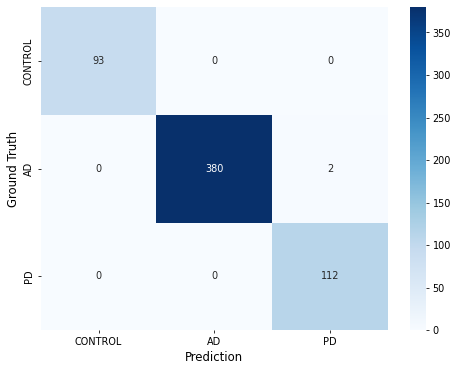

In [64]:
cnf = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k',)
ax = sns.heatmap(cnf, cmap='Blues',annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
#plt.title('Alzheimer\'s and Parkinson \'s Disease Classification')
plt.xlabel('Prediction',fontsize=12)
plt.ylabel('Ground Truth',fontsize=12)
plt.show(ax)

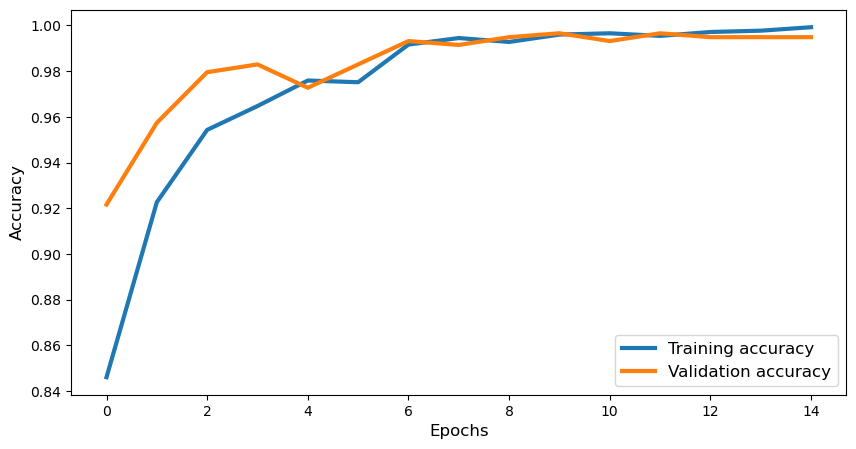

In [58]:
# Assuming `history` is the history object from your efficientB0 model training
df = pd.DataFrame(history.history)

# Drop the 'lr' column
df = df.drop(columns=['lr'])
df = df.drop(columns=['loss'])
df = df.drop(columns=['val_loss'])

# Plotting
ax = df.plot(figsize=(10, 5), lw=3)

# Customizing the plot
#ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)

# Set legend labels
#ax.legend(['Training Loss',  'Training Accuracy','Validation Loss', 'Validation Accuracy'], fontsize=12)
ax.legend(['Training accuracy','Validation accuracy'], fontsize=12)

# Show the plot
plt.show()

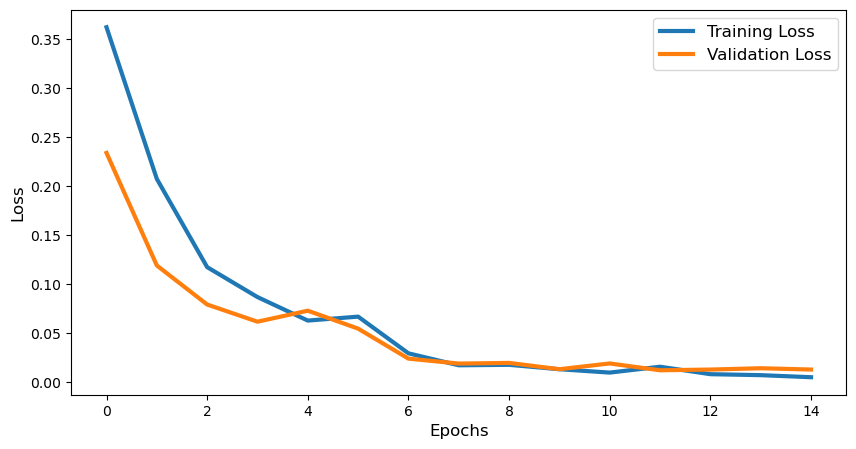

In [61]:
# Assuming `history` is the history object from your efficientB0 model training
df = pd.DataFrame(history.history)

# Drop the 'lr' column
df = df.drop(columns=['lr'])
df = df.drop(columns=['acc'])
df = df.drop(columns=['val_acc'])

# Plotting
ax = df.plot(figsize=(10, 5), lw=3)

# Customizing the plot
#ax.set_title('History per Epoch', fontsize=12)
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)

# Set legend labels
#ax.legend(['Training Loss',  'Training Accuracy','Validation Loss', 'Validation Accuracy'], fontsize=12)
ax.legend(['Training Loss', 'Validation Loss'], fontsize=12)

# Show the plot
plt.show()

In [22]:
model.save("Modified_Model2_classification PET_PNG_dataset_10_04_2024_10_04_2024.h5")

# Uploading Image and Showing its Class

In [ ]:
"""
#To be attended

import pydot
import pydotplus
# Load the saved model
saved_model = load_model('Model2_classification between AD and PD using new_dataset_efficient_net_B0_03_03_2024.h5')

# Convert the model to a Pydot graph
pydot_graph = model_to_dot(saved_model, show_shapes=True, show_layer_names=True)

# Use Graphviz to render the Pydot graph
graph = pydot_graph.create(prog='dot', format='png')

# Save the rendered graph as a PNG file
graph.write_png('model_architecture.png')
"""

In [45]:
#Load a model
model = load_model('Modified_Model2_classification PET_PNG_dataset_10_04_2024_10_04_2024.h5')

In [ ]:
label_map = {0: 'CONTROL', 1: 'AD', 2: 'PD'}

# Display 20 random images along with their labels
fig, axes = plt.subplots(5, 4, figsize=(15, 15))

for i, index in enumerate(indices[:20]):
    ax = axes[i // 4, i % 4]
    image = X_test[index].astype("uint8")  # Convert to uint8 data type
    actual_label = label_map[np.argmax(Y_test[index])]  # Convert actual label to string using label_map
    predicted_label = label_map[np.argmax(Y_pred[index])]  # Assuming Y_pred is one-hot encoded, use argmax to get the predicted class
    
    ax.axis('off')
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title("True Label: " + actual_label + '\nPredicted Label: ' + predicted_label,
                 fontsize=12, style='italic', color='blue')

plt.tight_layout()
plt.show()

100%|██████████| 250/250 [00:00<00:00, 754.37it/s]


46/46 [==============================] - 5s 103ms/step


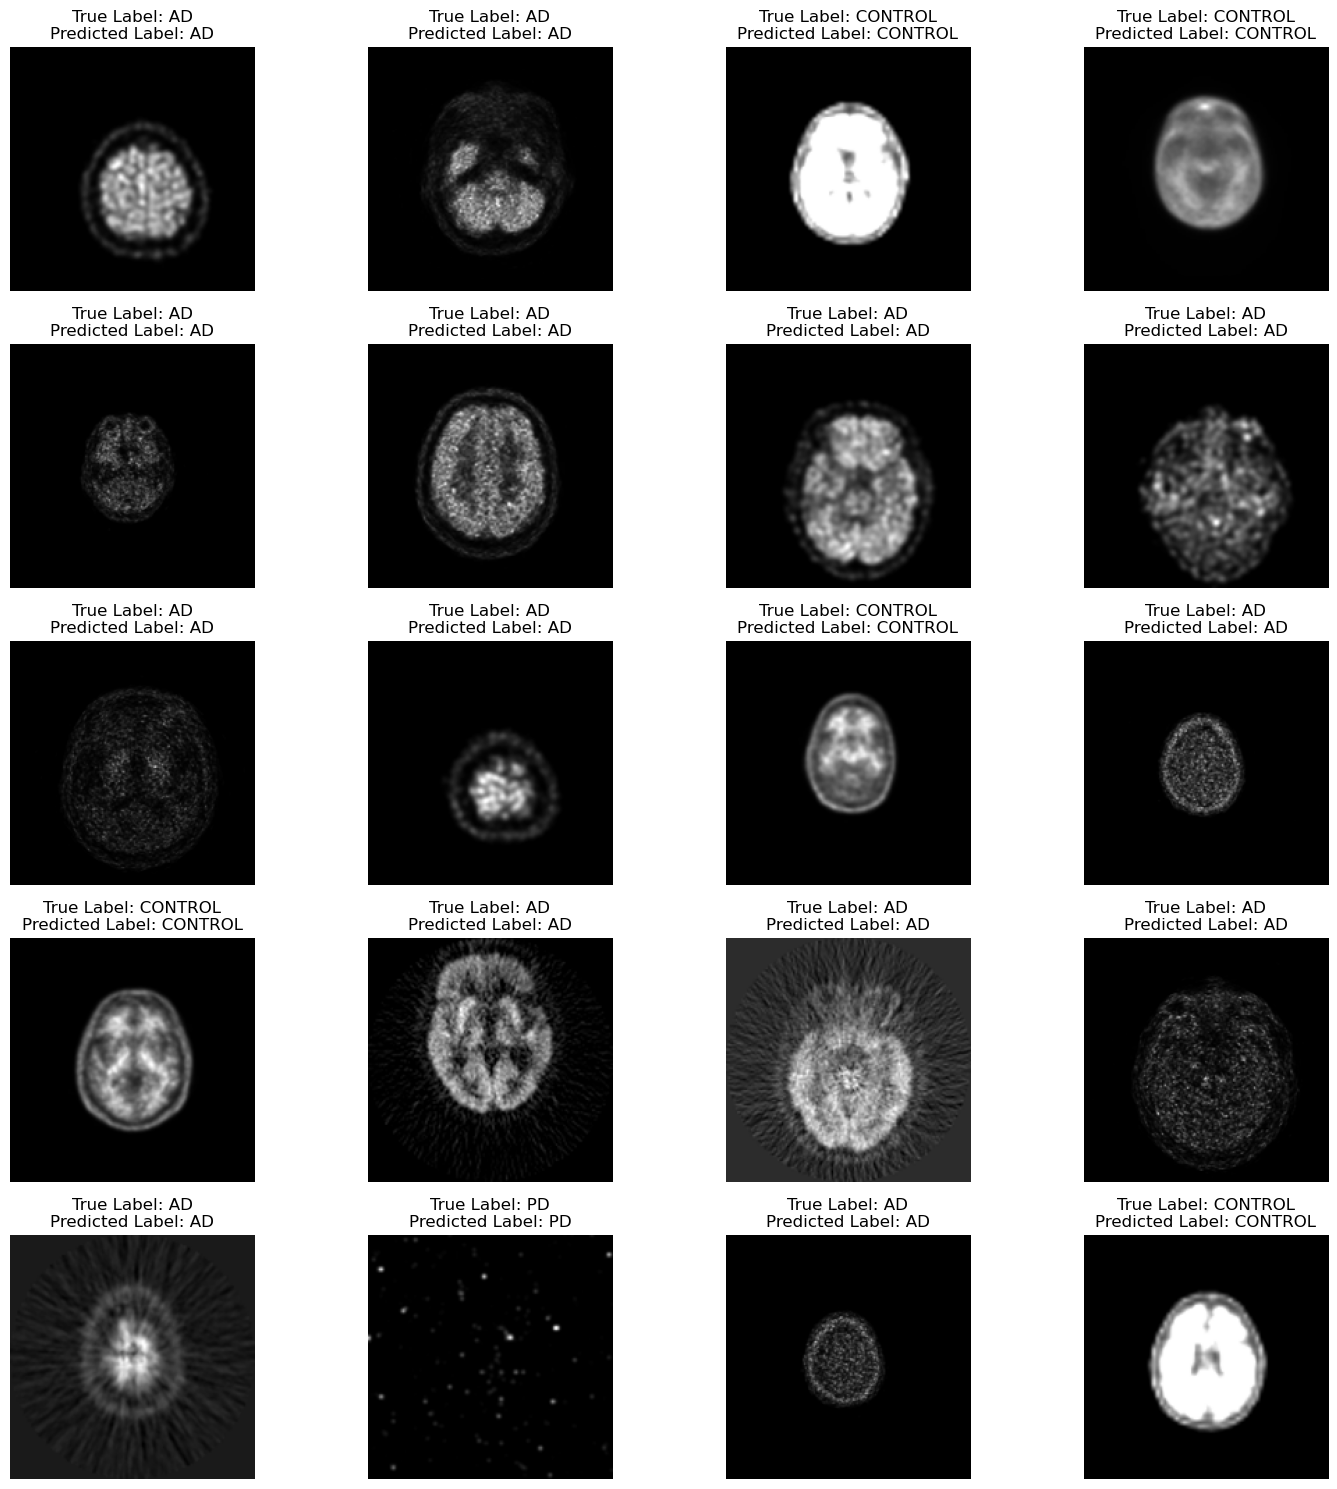

In [71]:
#PREDICTION OF IMAGES IN BATCH

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load your model and make predictions
# Assuming you have trained your model and obtained predictions in Y_pred

# Define a function to load and preprocess images
def load_images(folder_path, image_size):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)
        for image_file in tqdm(os.listdir(label_folder)):
            image_path = os.path.join(label_folder, image_file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (image_size, image_size))
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load test images and labels
test_folder = 'C:\\Users\\IDDY R SWALEHE\\Desktop\\PET_PNG_FINAL\\test'
X_test, Y_test = load_images(test_folder, image_size=176)

# Make predictions on the test set (assuming you have a trained model and Y_pred is obtained)
Y_pred = model.predict(X_test)

# Mapping dictionary for converting numeric predictions to labels
label_map = {0: 'CONTROL', 1: 'AD', 2: 'PD'}

# Shuffle the indices of the test set
indices = np.arange(len(X_test))
np.random.shuffle(indices)

# Display 20 random images along with their labels
fig, axes = plt.subplots(5, 4, figsize=(15, 15))

for i, index in enumerate(indices[:20]):
    ax = axes[i // 4, i % 4]
    image = X_test[index].astype("uint8")  # Convert to uint8 data type
    actual_label = Y_test[index]
    predicted_label = np.argmax(Y_pred[index])  # Assuming Y_pred is one-hot encoded, use argmax to get the predicted class
    predicted_label = label_map[predicted_label]  # Convert numeric prediction to label
    
    ax.axis('off')
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title("True Label: " + actual_label + '\nPredicted Label: ' + predicted_label,
                 fontsize=12, color='black')

plt.tight_layout()
plt.show()

